In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/bike-sharing-demand/test.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/sampleSubmission.csv


# Importing important libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

# Loading the training dataset

In [3]:
#Reading the file
file = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")

In [4]:
file.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# Checking for null values

In [5]:
file.isnull().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No data cleaning is required since no Null values are found!

In [6]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

# Data visualization:

## Heatmap of all the continuous values in the file.

In [7]:
corr = file[['temp','atemp','humidity', 'windspeed','casual', 'registered','count']].corr()

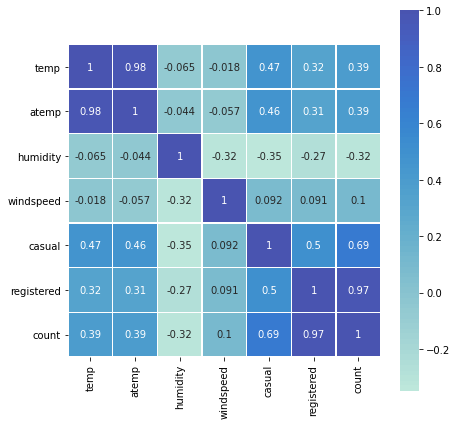

In [8]:
f,axes = plt.subplots(1,1,figsize = (7,7))
sb.heatmap(corr,square=True,annot = True,linewidth = .5,center = 2,ax = axes)

### The conclusions drawn are:
1. We can see that temp and atemp have a very strong positive correlation therefore we can use only temp as a variable without any loss of information. 

2. We can infer from the correlaton matrix that windspeed has almost no correlation with the casual,registered or count which we wish to predict so we can remove that

## Data visualizaton for non continuous variables in data

First we have to separate the individual date and time for each data point into hour,day,month and year.

In [9]:
file = file
file['Date'] = pd.DatetimeIndex(file['datetime']).date
file['Hour'] = pd.DatetimeIndex(file['datetime']).hour
file['Day'] = pd.DatetimeIndex(file['datetime']).day
file['Month'] = pd.DatetimeIndex(file['datetime']).month
file['Year'] = pd.DatetimeIndex(file['datetime']).year

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


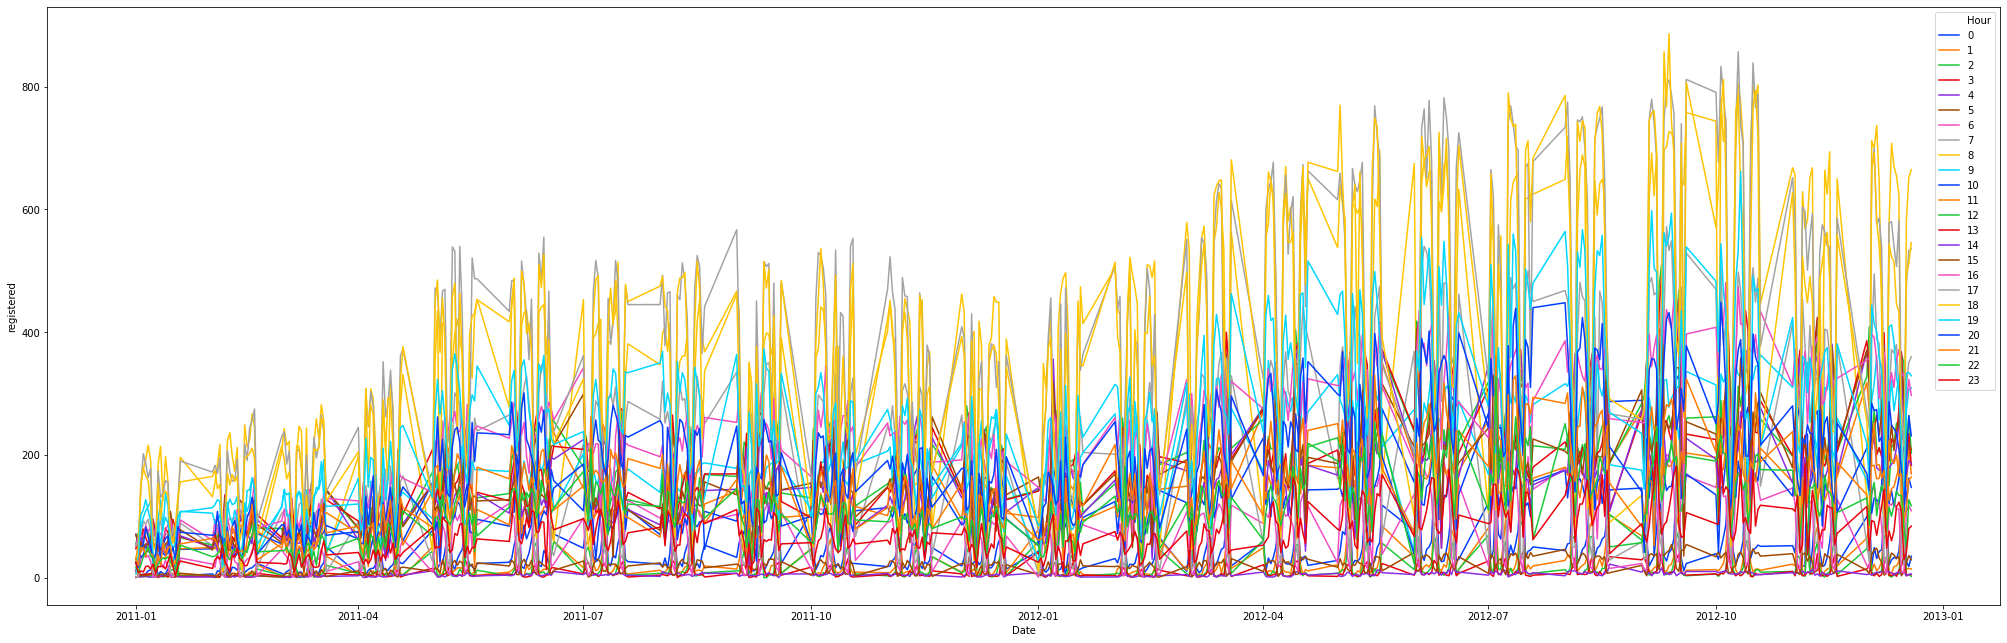

In [10]:
f,axes = plt.subplots(1,1,figsize = (35,11))
sb.lineplot(x ='Date', y = 'registered', data = file, hue = 'Hour',ax = axes,legend = 'full',palette = 'bright')

**The sudden periodic changes between the differrent regions is due to the missing data.These are the regions in which the regions we have to predict the result.**

## 1. Season

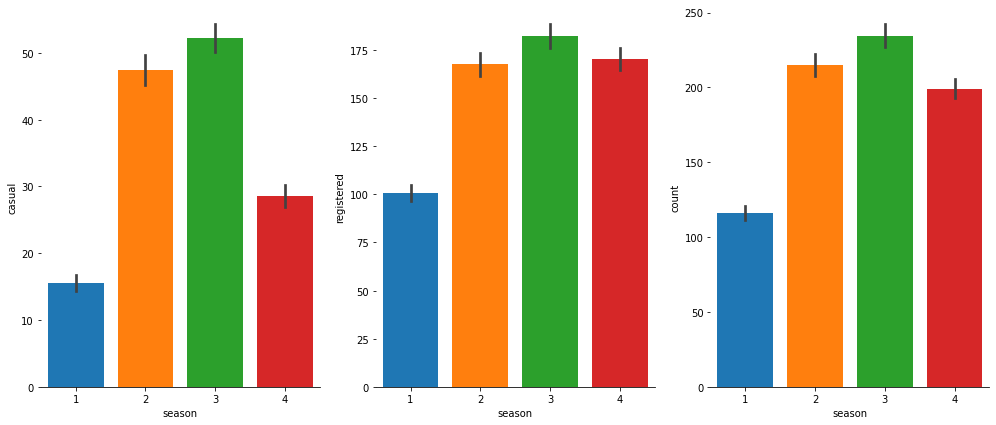

In [11]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'season'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 2. Holiday

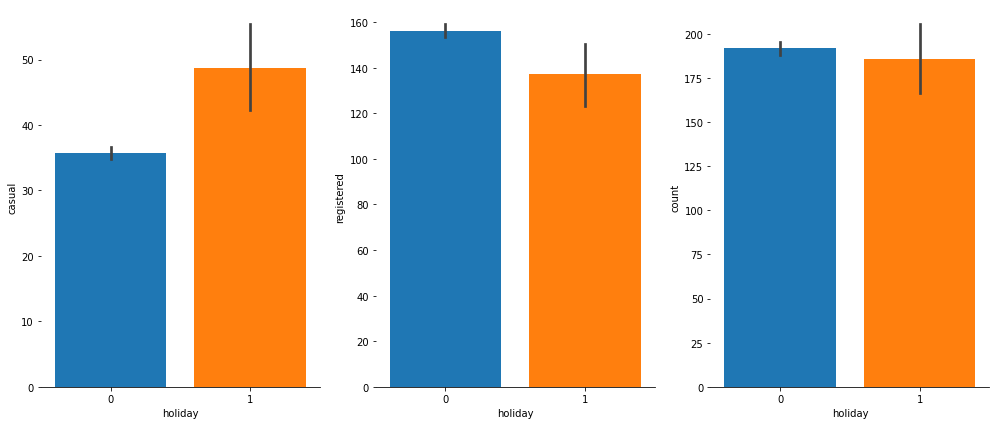

In [12]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'holiday'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 3. Working day

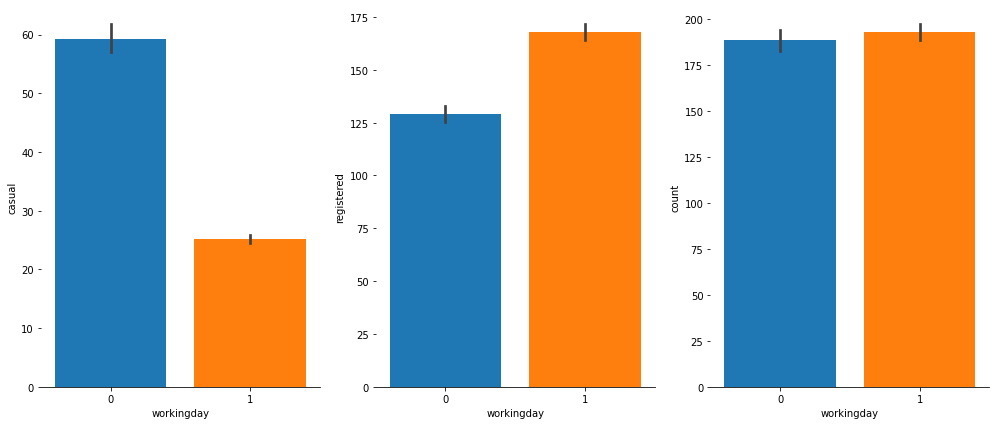

In [13]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'workingday'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

Combining the graphs of casual and registered into one of may make it seem like that holiday and workingday have no dependence on count but we can clearly see that holiday increases the casual amount by upto 40% and a reverse kind of trend is observed in working day so it is reasonable to take two different models one for casual and another for registered.

Therefore what I will attempt to do is make two separate models for the casual and the registerd training them separately and then adding the result to get the count.

## 4. Weather

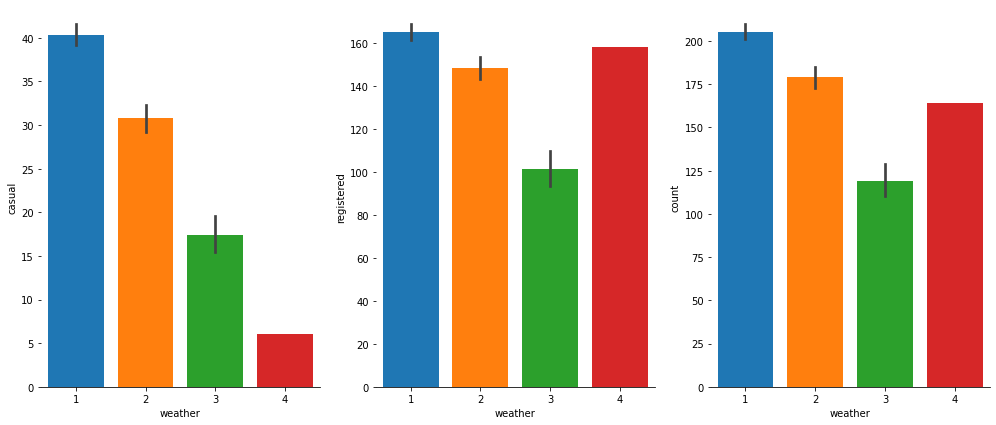

In [14]:
f,axes = plt.subplots(1,3,figsize = (17,7))
sb.despine(left = True)
x = 'weather'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

## 5. Date and Time

### 5.a. Hour

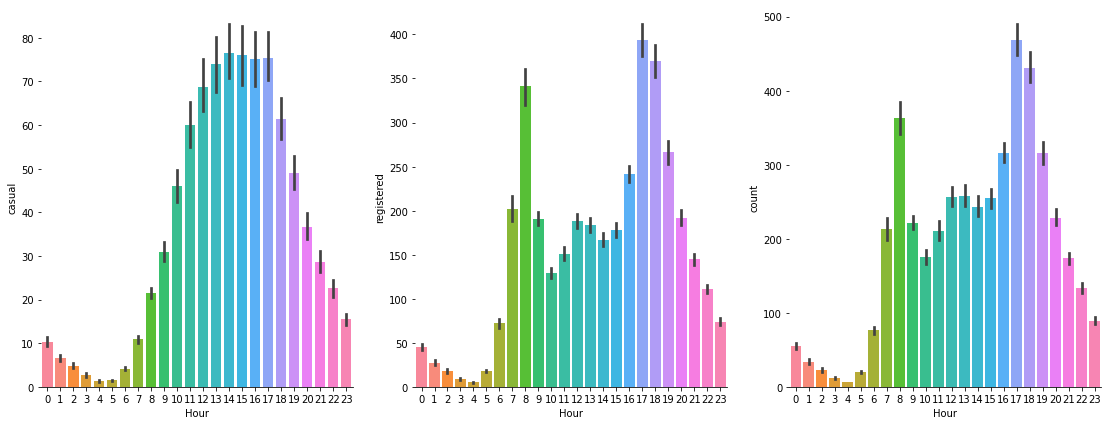

In [15]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Hour'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

We can see that in the final graph there are two prominent peaks.
1. At 8 a.m
2. At 5 p.m
Where as the trend of casual is mostly the same throughout the day. 

From this we can conclude that the registered are mostly people going on their jobs which explains the peaks at the start and end of office hours. Clearly these people would have a more definite and predictible schedule and are therefore more likely to be registered.

### 5.b. Day

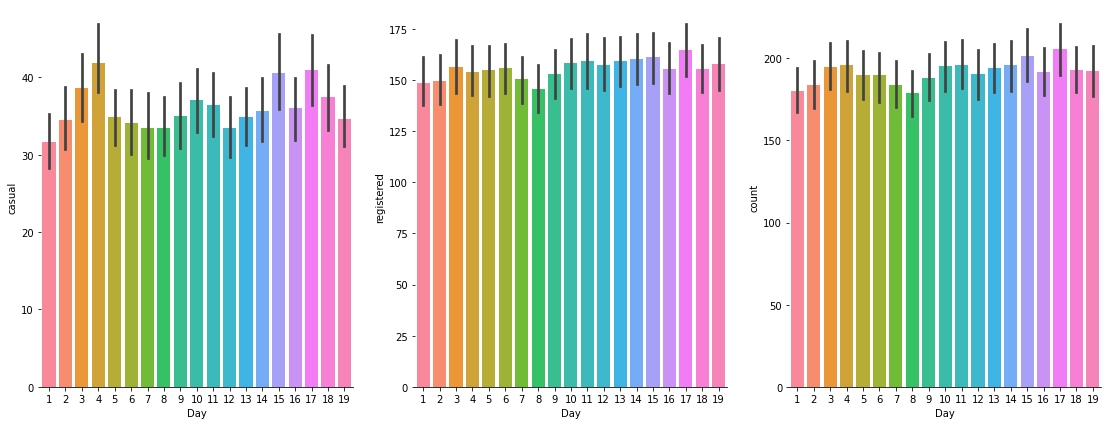

In [16]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Day'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

**From the above graphs we can conclude that the feature day has hardly any influence over the features registered and count.**

### 5.c. Month

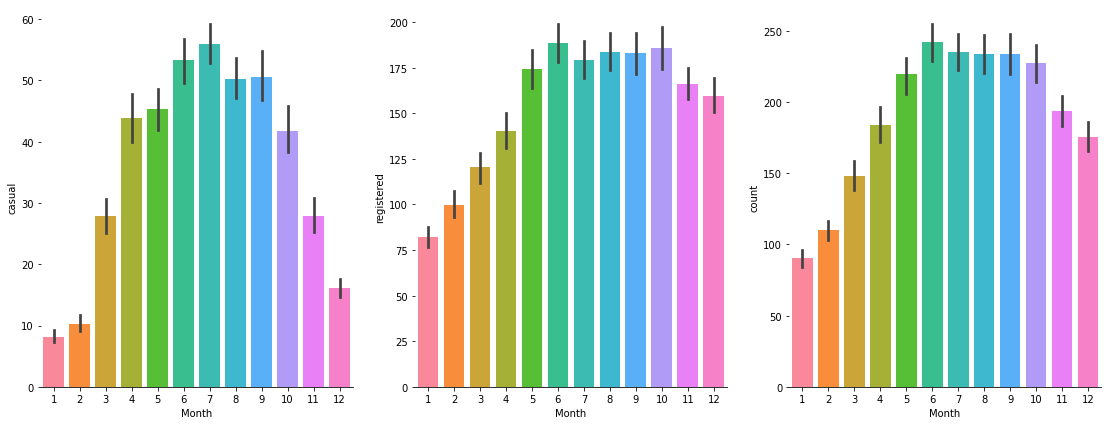

In [17]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Month'
#order = ['January','February','March','April','May','June','July','August','September','October','November','December']
plot = sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0])
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

### 5.d. Year 

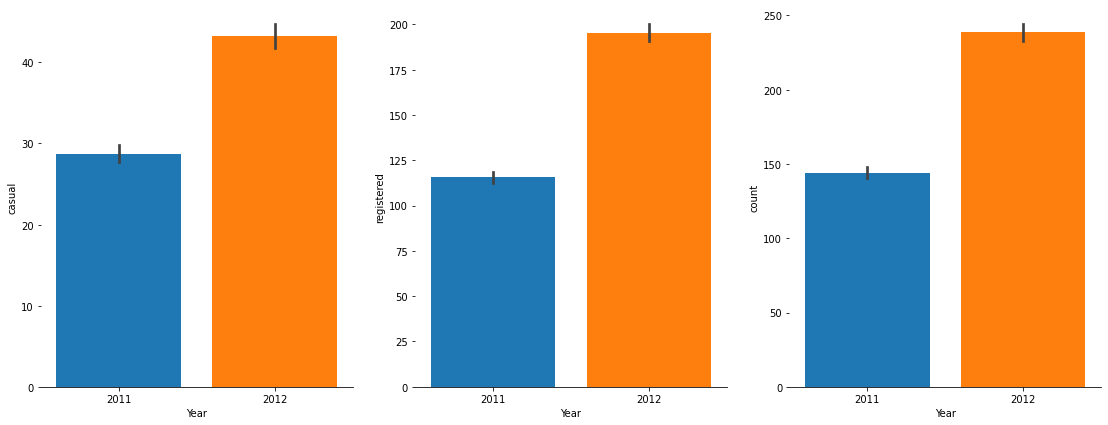

In [18]:
f,axes = plt.subplots(1,3,figsize = (19,7))
sb.despine(left = True)
x = 'Year'

sb.barplot(x = x , y = 'casual' , data = file, saturation = 1, ax =  axes[0] ,)
sb.barplot(x = x , y = 'registered' , data = file, saturation = 1, ax = axes[1])
sb.barplot(x = x , y = 'count' , data = file, saturation = 1, ax = axes[2])

In [19]:
file.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,Hour,Day,Month,Year
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,9.992559,6.521495,2011.501929
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,5.476608,3.444373,0.500019
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,5.000000,4.000000,2011.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,10.000000,7.000000,2012.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,15.000000,10.000000,2012.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,19.000000,12.000000,2012.000000


In [20]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year'],
      dtype='object')

# Adding relevant columns for each of the categorical data columns and removing unnecesary ones

## 1. Season

In [21]:
for i in file.groupby('season').count().index:
    s = 's'+str(i)
    a=[]
    for j in file.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,count,Date,Hour,Day,Month,Year,s1,s2,s3,s4
858,2011-02-19 05:00:00,1,0,0,1,16.40,20.455,15,22.0028,0,...,3,2011-02-19,5,19,2,2011,1,0,0,0
10193,2012-11-10 03:00:00,4,0,0,1,12.30,16.665,81,0.0000,9,...,20,2012-11-10,3,10,11,2012,0,0,0,1
4692,2011-11-08 14:00:00,4,0,1,1,22.96,26.515,46,7.0015,32,...,161,2011-11-08,14,8,11,2011,0,0,0,1
4328,2011-10-12 09:00:00,4,0,1,2,22.14,25.760,88,30.0026,14,...,197,2011-10-12,9,12,10,2011,0,0,0,1
613,2011-02-08 17:00:00,1,0,1,1,9.02,9.090,32,39.0007,4,...,176,2011-02-08,17,8,2,2011,1,0,0,0


## 2. Weather 

In [22]:
for i in file.groupby('weather').count().index:
    s = 'w'+str(i)
    a=[]
    for j in file.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Month,Year,s1,s2,s3,s4,w1,w2,w3,w4
7089,2012-04-13 18:00:00,2,0,1,1,22.14,25.760,26,8.9981,107,...,4,2012,0,1,0,0,1,0,0,0
8842,2012-08-10 19:00:00,3,0,1,1,31.16,35.605,62,19.0012,98,...,8,2012,0,0,1,0,1,0,0,0
2503,2011-06-12 05:00:00,2,0,0,1,25.42,28.030,88,15.0013,5,...,6,2011,0,1,0,0,1,0,0,0
7716,2012-06-01 21:00:00,2,0,1,3,26.24,29.545,78,16.9979,12,...,6,2012,0,1,0,0,0,0,1,0
4276,2011-10-10 05:00:00,4,1,0,1,18.86,22.725,94,0.0000,2,...,10,2011,0,0,0,1,1,0,0,0


## 3. Hour

In [23]:
for i in file.groupby('Hour').count().index:
    s = 'Hour'+str(i)
    a=[]
    for j in file.Hour:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s]=a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Hour14,Hour15,Hour16,Hour17,Hour18,Hour19,Hour20,Hour21,Hour22,Hour23
7035,2012-04-11 12:00:00,2,0,1,2,14.76,16.665,46,26.0027,35,...,0,0,0,0,0,0,0,0,0,0
5827,2012-01-18 00:00:00,1,0,1,2,18.86,22.725,77,22.0028,3,...,0,0,0,0,0,0,0,0,0,0
4840,2011-11-14 18:00:00,4,0,1,1,22.96,26.515,56,19.0012,29,...,0,0,0,0,1,0,0,0,0,0
7275,2012-05-02 12:00:00,2,0,1,2,23.78,27.275,83,15.0013,35,...,0,0,0,0,0,0,0,0,0,0
6044,2012-02-08 02:00:00,1,0,1,1,10.66,15.150,65,0.0000,0,...,0,0,0,0,0,0,0,0,0,0


## 4.Month

In [24]:
for i in file.groupby("Month").count().index:
    s = 'Month' + str(i)
    a = []
    for j in file.Month:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    file[s] = a
file.sample(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12
4003,2011-09-17 20:00:00,3,0,0,1,21.32,25.000,68,8.9981,43,...,0,0,0,0,0,0,1,0,0,0
2068,2011-05-13 02:00:00,2,0,1,2,20.50,24.240,88,8.9981,3,...,0,0,1,0,0,0,0,0,0,0
8441,2012-07-13 02:00:00,3,0,1,2,27.06,31.060,61,6.0032,2,...,0,0,0,0,1,0,0,0,0,0
969,2011-03-04 20:00:00,1,0,1,2,12.30,14.395,70,12.9980,9,...,1,0,0,0,0,0,0,0,0,0
2795,2011-07-05 09:00:00,3,0,1,1,30.34,34.090,58,8.9981,50,...,0,0,0,0,1,0,0,0,0,0


In [25]:
file.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'Date', 'Hour', 'Day', 'Month', 'Year', 's1', 's2', 's3', 's4', 'w1',
       'w2', 'w3', 'w4', 'Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5',
       'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12',
       'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19',
       'Hour20', 'Hour21', 'Hour22', 'Hour23', 'Month1', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12'],
      dtype='object')

## Removing unnecessary columns

In [26]:
feed = file[['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5',
       'Hour6', 'Hour7', 'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12',
       'Hour13', 'Hour14', 'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19',
       'Hour20', 'Hour21', 'Hour22', 'Hour23','Month1', 'Month2', 'Month3',
       'Month4', 'Month5', 'Month6', 'Month7', 'Month8', 'Month9', 'Month10',
       'Month11', 'Month12','Year','s1','s2','s3','s4','holiday','workingday',
        'w1','w2','w3','w4','temp','humidity','casual','registered']]

In [27]:
feed.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,holiday,workingday,w1,w2,w3,w4,temp,humidity,casual,registered
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460,36.021955,155.552177
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033,49.960477,151.039033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000,4.000000,36.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000,17.000000,118.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000,49.000000,222.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000,367.000000,886.000000


In [28]:
feed.columns

Index(['Hour0', 'Hour1', 'Hour2', 'Hour3', 'Hour4', 'Hour5', 'Hour6', 'Hour7',
       'Hour8', 'Hour9', 'Hour10', 'Hour11', 'Hour12', 'Hour13', 'Hour14',
       'Hour15', 'Hour16', 'Hour17', 'Hour18', 'Hour19', 'Hour20', 'Hour21',
       'Hour22', 'Hour23', 'Month1', 'Month2', 'Month3', 'Month4', 'Month5',
       'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12',
       'Year', 's1', 's2', 's3', 's4', 'holiday', 'workingday', 'w1', 'w2',
       'w3', 'w4', 'temp', 'humidity', 'casual', 'registered'],
      dtype='object')

# Preparing training and testing sets

### 1. Training set

In [29]:
df_train_x = feed.drop('casual',axis = 1).drop('registered',axis=1)
df_train_x.describe()

,Hour0,Hour1,Hour2,Hour3,Hour4,Hour5,Hour6,Hour7,Hour8,Hour9,...,s3,s4,holiday,workingday,w1,w2,w3,w4,temp,humidity
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,...,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000
mean,0.041797,0.041705,0.041154,0.039776,0.040603,0.041521,0.041797,0.041797,0.041797,0.041797,...,0.251056,0.251148,0.028569,0.680875,0.660665,0.260334,0.078909,0.000092,20.23086,61.886460
std,0.200134,0.199923,0.198655,0.195441,0.197377,0.199502,0.200134,0.200134,0.200134,0.200134,...,0.433641,0.433694,0.166599,0.466159,0.473505,0.438837,0.269609,0.009584,7.79159,19.245033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.82000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.94000,47.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,20.50000,62.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,26.24000,77.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,41.00000,100.000000


### 2. Training set

In [30]:
df_reg_train_y = feed['registered']
df_reg_train_y.describe

<bound method NDFrame.describe of 0         13
1         32
2         27
3         10
4          1
        ... 
10881    329
10882    231
10883    164
10884    117
10885     84
Name: registered, Length: 10886, dtype: int64>

In [31]:
df_cas_train_y = feed['casual']
df_cas_train_y.describe

<bound method NDFrame.describe of 0         3
1         8
2         5
3         3
4         0
         ..
10881     7
10882    10
10883     4
10884    12
10885     4
Name: casual, Length: 10886, dtype: int64>

# Machine learning model

### Splitting data into train and test sets

In [32]:
x1_train, x1_test, y1_train, y1_test = train_test_split(df_train_x, df_cas_train_y, test_size=0.15, random_state=42)
x2_train, x2_test, y2_train, y2_test = train_test_split(df_train_x, df_reg_train_y, test_size=0.15, random_state=42)

### Using polynomial on the dataset

In [33]:
poly = PolynomialFeatures(degree=2)
poly_x1_train = poly.fit_transform(x1_train)
poly_x1_test = poly.fit_transform(x1_test)
poly_x2_train = poly.fit_transform(x2_train)
poly_x2_test = poly.fit_transform(x2_test)

### Trying different models to see which one works best for the given data.

In [34]:
predict1=[]
for i in range (0,60,5):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x1_train, y1_train)
    pre_dt = dt.predict(x1_test)
    predict1.append(pre_dt)
i=0
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i*5+1)+" : "+str(np.sqrt(mean_squared_log_error( y1_test, pre ))))
    i+=1

1 : 1.5572847807383274
6 : 1.0888180694560847
11 : 0.8698229035838374
16 : 0.7303870783629551
21 : 0.6663852438367559
26 : 0.6561388956960268
31 : 0.6507901565651444
36 : 0.6503407614247844
41 : 0.6539832751355547
46 : 0.6488920121809657
51 : 0.6465956729850549
56 : 0.6470994624387947


We can see that the minimum must occur between i=21 and 1=41

In [35]:
predict1=[]
for i in range (20,40,2):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x1_train, y1_train)
    pre_dt = dt.predict(x1_test)
    predict1.append(pre_dt)
i=20
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i*2+1)+" : "+str(np.sqrt(mean_squared_log_error( y1_test, pre ))))
    i+=1

41 : 0.6642081366997034
43 : 0.6604479148584217
45 : 0.6514574923992199
47 : 0.6495070475729806
49 : 0.6465987436568127
51 : 0.6468857738286188
53 : 0.6487647935608977
55 : 0.6463348167946121
57 : 0.6516313073008091
59 : 0.6471747295774941


We can conclude that the optimal value for depth = 50 for the random forest after which it starts to overfit for casual.

**P.S: The actual minimum values may vary from instance to instance due to the randomness in the trees generated however the optimal depth will be more or less the same compared to the optimal chosen value**

In [36]:
predict1=[]
for i in range (0,70,5):
    dt = RandomForestRegressor(n_estimators=100,max_depth=i+1).fit(x2_train, y2_train)
    pre_dt = dt.predict(x2_test)
    predict1.append(pre_dt)
i=0
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (5*i+1)+" : "+str(np.sqrt(mean_squared_log_error( y2_test, pre ))))
    i+=1

1 : 1.556819023350849
6 : 1.3336715885245694
11 : 0.9959532615890945
16 : 0.6981111048704162
21 : 0.5015108978459338
26 : 0.4173390105841068
31 : 0.4156653374274039
36 : 0.4151029461621542
41 : 0.4214545046646772
46 : 0.41444431944347687
51 : 0.41468456949695576
56 : 0.41005859048417187
61 : 0.4120753713913537
66 : 0.4167255420928953


We can see that the minimum must occur between i = 56  and i = 66

In [37]:
predict1=[]
for i in range (55,65,1):
    dt = RandomForestRegressor(n_estimators = 100,max_depth=i+1).fit(x2_train, y2_train)
    pre_dt = dt.predict(x2_test)
    predict1.append(pre_dt)
i=55
for prediction in predict1:
    pre = []
    for p in prediction:
        if p < 0:
            pre.append(0)
        else:
            pre.append(p)
    print(str (i+1)+" : "+str(np.sqrt(mean_squared_log_error( y2_test, pre ))))
    i+=1

56 : 0.4149905747376881
57 : 0.4211096886882514
58 : 0.41367895010228567
59 : 0.41830469255114844
60 : 0.42285035985058733
61 : 0.41494450486590745
62 : 0.42323036297241196
63 : 0.41076844155245473
64 : 0.4183048208428383
65 : 0.41512611214875333


We can conclude that the optimal value for depth = 60 for the random forest after which it starts to overfit for registered.

**P.S: The actual minimum values may vary from instance to instance due to the randomness in the trees generated however the optimal depth will be more or less the same compared to the optimal chosen value**

In [38]:
predict1 = []

reg1 = LinearRegression().fit(x1_train, y1_train)
pre_reg1 = reg1.predict(x1_test)

reg1_poly = LinearRegression().fit(poly_x1_train, y1_train)
pre_reg1_poly = reg1_poly.predict(poly_x1_test)

rf1 = RandomForestRegressor(n_estimators = 100,max_depth=50).fit(x1_train, y1_train)
pre_rf1 = rf1.predict(x1_test)

for i in range(pre_reg1.size):
    if pre_reg1[i]<1:
        pre_reg1[i] = 1 
    if pre_reg1_poly[i]<1:
        pre_reg1_poly[i] = 1
    if pre_rf1[i]<1:
        pre_rf1[i] = 1

predict1.append(pre_reg1)
predict1.append(pre_reg1_poly)
predict1.append(pre_rf1)



for prediction in predict1:
    print(np.sqrt(mean_squared_log_error( y1_test, prediction )))

1.021087822864223
0.8901384204865517
0.6480576451480154


Since we know that the output is never less than 1 we replace all negative values with 1 before appending in pre to calculate error.

In [39]:
predict2 = []

reg2 = LinearRegression().fit(x2_train, y2_train)
pre_reg2 = reg2.predict(x2_test)

reg2_poly = LinearRegression().fit(poly_x2_train, y2_train)
pre_reg2_poly = reg2_poly.predict(poly_x2_test)

rf2 = RandomForestRegressor(n_estimators = 100,max_depth=60).fit(x2_train, y2_train)
pre_rf2 = rf2.predict(x2_test)

for i in range(pre_reg2.size):
    if pre_reg2[i]<1:
        pre_reg2[i] = 1 
    if pre_reg2_poly[i]<1:
        pre_reg2_poly[i] = 1
    if pre_rf2[i]<1:
        pre_rf2[i] = 1

predict2.append(pre_reg2)
predict2.append(pre_reg2_poly)
predict2.append(pre_rf2)

for prediction in predict2:
    print(np.sqrt(mean_squared_log_error( y2_test, prediction )))

1.004323087654508
0.6565935912143859
0.41301503830336483


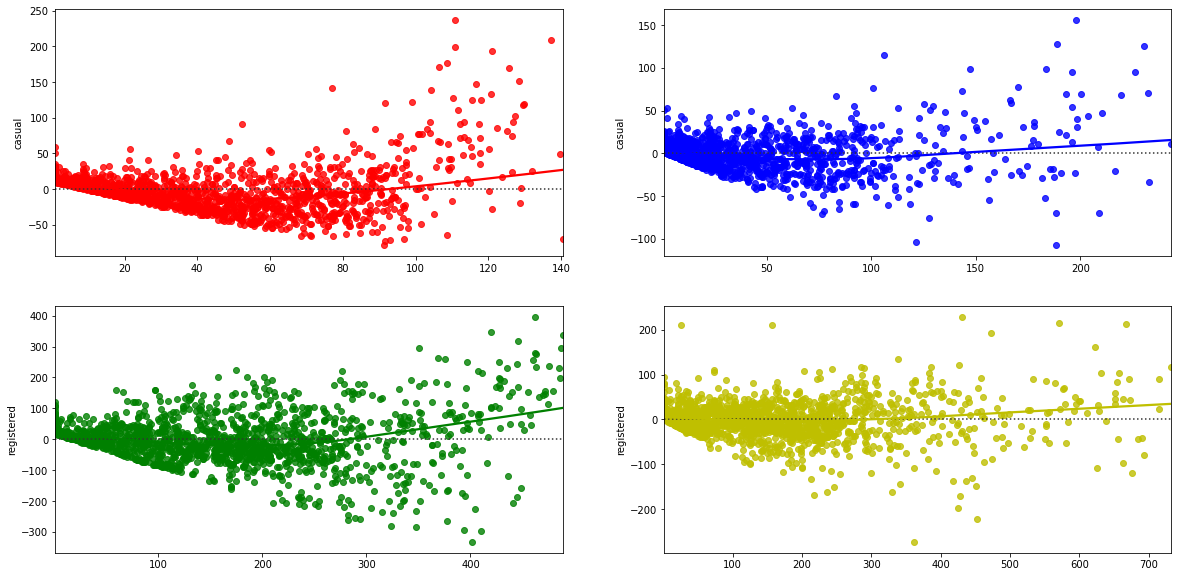

In [40]:
f,axes = plt.subplots(2,2,figsize = (20,10))
r1 = sb.residplot(x = pre_reg1, y = y1_test,lowess = True,color = 'r',ax = axes[0,0])
r2 = sb.residplot(x = pre_reg1_poly, y = y1_test,lowess = True,color = 'b',ax = axes[0,1])
r3 = sb.residplot(x = pre_reg2,y = y2_test,lowess = True,color = 'g',ax = axes[1,0])
r4 = sb.residplot(x = pre_reg2_poly, y = y2_test,lowess = True,color = 'y',ax = axes[1,1])

**Since the residual plots show a conical divergence therefore we can conclude that Linear Regression is definitely not a suitable model for the predicting in the above distribution of data**

Clearly the random forest model works best in this situation.

### Retraining the decision tree over the whole dataset for submission.

In [41]:
rf1 = RandomForestRegressor(max_depth = 50).fit(df_train_x,df_cas_train_y)
rf2 = RandomForestRegressor(max_depth = 60).fit(df_train_x,df_reg_train_y)

### Reading the test file

In [42]:
test_file = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [43]:
test=test_file
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


## Processing of the test file

In [44]:
test['mth'] = pd.DatetimeIndex(test['datetime']).month
test['yr'] = pd.DatetimeIndex(test['datetime']).year
test['dy'] = pd.DatetimeIndex(test['datetime']).day
test['hr'] = pd.DatetimeIndex(test['datetime']).hour

for i in test.groupby("season").count().index:
    s = 's' + str(i)
    a = []
    for j in test.season:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby("weather").count().index:
    s = 'w' + str(i)
    a = []
    for j in test.weather:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
for i in test.groupby('hr').count().index:
    s = 'hr'+str(i)
    a=[]
    for j in test.hr:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s]=a
for i in test.groupby("mth").count().index:
    s = 'm' + str(i)
    a = []
    for j in test.mth:
        if j==i:
            a.append(1)
        else:
            a.append(0)
    test[s] = a
test.sample(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,mth,...,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
2770,2011-11-23 23:00:00,4,0,1,1,13.94,15.150,61,23.9994,11,...,0,0,0,0,0,0,0,0,1,0
164,2011-01-28 00:00:00,1,0,1,2,8.20,10.605,75,8.9981,1,...,0,0,0,0,0,0,0,0,0,0
5247,2012-08-24 11:00:00,3,0,1,2,31.16,34.090,48,7.0015,8,...,0,0,0,0,0,1,0,0,0,0
167,2011-01-28 03:00:00,1,0,1,2,8.20,11.365,75,7.0015,1,...,0,0,0,0,0,0,0,0,0,0
5384,2012-08-30 04:00:00,3,0,1,1,25.42,29.545,73,0.0000,8,...,0,0,0,0,0,1,0,0,0,0
935,2011-04-27 23:00:00,2,0,1,2,25.42,28.030,88,23.9994,4,...,0,1,0,0,0,0,0,0,0,0
4466,2012-05-26 22:00:00,2,0,0,1,28.70,33.335,74,16.9979,5,...,0,0,1,0,0,0,0,0,0,0
4061,2012-04-21 01:00:00,2,0,0,1,21.32,25.000,77,15.0013,4,...,0,1,0,0,0,0,0,0,0,0
2662,2011-10-31 11:00:00,4,0,1,1,16.40,20.455,50,8.9981,10,...,0,0,0,0,0,0,0,1,0,0
1957,2011-08-24 13:00:00,3,0,1,1,31.16,34.090,48,27.9993,8,...,0,0,0,0,0,1,0,0,0,0


In [45]:
test = test[['hr0','hr1','hr2','hr3','hr4','hr5','hr6','hr7','hr8','hr9','hr10','hr11','hr12','hr13','hr14','hr15','hr16','hr17','hr18',
                 'hr19','hr20','hr21','hr22','hr23','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','yr',
                 's1','s2','s3','s4','holiday','workingday','w1','w2','w3','w4','temp','humidity']]
test.describe

<bound method NDFrame.describe of       hr0  hr1  hr2  hr3  hr4  hr5  hr6  hr7  hr8  hr9  ...  s3  s4  holiday  \
0       1    0    0    0    0    0    0    0    0    0  ...   0   0        0   
1       0    1    0    0    0    0    0    0    0    0  ...   0   0        0   
2       0    0    1    0    0    0    0    0    0    0  ...   0   0        0   
3       0    0    0    1    0    0    0    0    0    0  ...   0   0        0   
4       0    0    0    0    1    0    0    0    0    0  ...   0   0        0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..      ...   
6488    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6489    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6490    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6491    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   
6492    0    0    0    0    0    0    0    0    0    0  ...   0   0        0   

     

## Predicting the output over test set

In [46]:
pre_cas = rf1.predict(test)
pre_reg = rf2.predict(test)
final_predictions = pd.DataFrame(pre_cas+pre_reg,columns = ['cout'])

final_predictions.describe

<bound method NDFrame.describe of             cout
0      13.634667
1       4.250000
2       3.728000
3       3.100000
4       2.805000
...          ...
6488  227.360000
6489  157.310000
6490  132.322500
6491   96.740000
6492   59.952000

[6493 rows x 1 columns]>

In [47]:
s=[]
for j in final_predictions.cout:
    if int(j)<1:
        s.append(1)
    else:
        s.append(j)
final_predictions['count'] = s 

**Since we know that the output is never less than 1 we have to replace all negative values with 1.**

In [48]:
final_predictions.describe

<bound method NDFrame.describe of             cout       count
0      13.634667   13.634667
1       4.250000    4.250000
2       3.728000    3.728000
3       3.100000    3.100000
4       2.805000    2.805000
...          ...         ...
6488  227.360000  227.360000
6489  157.310000  157.310000
6490  132.322500  132.322500
6491   96.740000   96.740000
6492   59.952000   59.952000

[6493 rows x 2 columns]>

In [49]:
final_predictions['datetime']=test_file['datetime']
final_predictions = final_predictions[['datetime','count']]

In [50]:
final_predictions.describe()

,count
count,6493.000000
mean,190.732120
std,171.543215
min,1.490000
25%,52.126667
50%,148.770000
75%,281.300000
max,908.370000


## Exporting output to csv

In [51]:
final_predictions.to_csv('submission.csv',index=False)